In [ ]:
import pandas as pd
import numpy as np
import re, pickle
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant

In [ ]:
# Load the data
df_original=pd.read_csv("/content/mental_health.csv")

In [ ]:
df_original.shape

(27977, 2)

In [ ]:
df_original.dtypes

,0
text,object
label,int64


In [ ]:
df_original["label"].unique()

array([0, 1])

In [ ]:
df_original.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [ ]:
# Train/val/test split
X_text = df["clean_text"].astype(str).tolist()
y = df["label"].astype(int).values

In [ ]:
X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_text, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
 df = pd.DataFrame({
     "clean_text": df_original["text"].apply(clean_text_lstm),
     "label": df_original["label"]})

In [ ]:
# Tokenize & pad
vocab_size = 40000
oov_token = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train_text)

In [ ]:
def to_seq(texts): return tokenizer.texts_to_sequences(texts)

In [ ]:
train_seqs = to_seq(X_train_text)
val_seqs   = to_seq(X_val_text)
test_seqs  = to_seq(X_test_text)

In [ ]:
# choose padding length from 95th percentile of training lengths
lengths = np.array([len(s) for s in train_seqs if len(s) > 0])
max_len = int(np.percentile(lengths, 95)) if len(lengths) else 50
print("Using pad length:", max_len)

Using pad length: 235


In [ ]:
X_train = pad_sequences(train_seqs, maxlen=max_len, padding="post", truncating="post")
X_val   = pad_sequences(val_seqs,   maxlen=max_len, padding="post", truncating="post")
X_test  = pad_sequences(test_seqs,  maxlen=max_len, padding="post", truncating="post")

In [ ]:
# Load GloVe and build embedding matrix
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove_data

embedding_dim = 100
embeddings_index = {}
with open(f"glove_data/glove.6B.{embedding_dim}d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

In [105]:
# Build model
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,          # <-- crucial so Keras knows sequence length
        trainable=False                # freeze GloVe
    ),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.30),
    Dense(64, activation="relu"),
    Dropout(0.30),
    Dense(1, activation="sigmoid")])

In [106]:
# Explicitly build so summary shows real shapes/params *before* training
model.build(input_shape=(None, max_len))
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 235, 100)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,251,009 (16.22 MB)

 Trainable params: 251,009 (980.50 KB)

 Non-trainable params: 4,000,000 (15.26 MB)

In [107]:
# Class weights
cw = dict(Counter(y_train))
total = sum(cw.values())
for k in cw:
    cw[k] = total / (len(cw) * cw[k])
print("Class weights:", cw)

Class weights: {np.int64(0): 0.9893466536999381, np.int64(1): 1.0108852755194218}


In [108]:
# Train
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
ckpt = ModelCheckpoint("best_glove_lstm.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    class_weight=cw,
    callbacks=[es, ckpt],
    verbose=1)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7719 - loss: 0.4833 - val_accuracy: 0.8663 - val_loss: 0.3159
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8710 - loss: 0.3071 - val_accuracy: 0.8781 - val_loss: 0.3025
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.8851 - loss: 0.2836 - val_accuracy: 0.8949 - val_loss: 0.2634
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9005 - loss: 0.2427 - val_accuracy: 0.9049 - val_loss: 0.2497
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9118 - loss: 0.2204 - val_accuracy: 0.9042 - val_loss: 0.2340
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9164 - loss: 0.2125 - val_accuracy: 0.9117 - val_loss: 0.2227
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9259 - loss: 0.1855 - val_accuracy: 0.9178 - val_loss: 0.2120
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9332 - loss: 0.1716 - val_accuracy: 0.9128 - v

In [109]:
# Evaluate
proba = model.predict(X_test).ravel()
preds = (proba >= 0.5).astype(int)

print("\nClassification report:")
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, preds, digits=4))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, preds))

88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step

Classification report:
              precision    recall  f1-score   support

           0     0.9143    0.9279    0.9210      1414
           1     0.9252    0.9111    0.9181      1384

    accuracy                         0.9196      2798
   macro avg     0.9197    0.9195    0.9196      2798
weighted avg     0.9197    0.9196    0.9196      2798


Confusion matrix:
[[1312  102]
 [ 123 1261]]


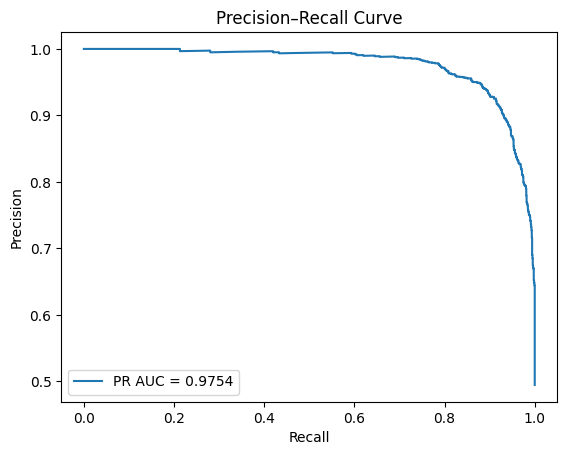

In [110]:
# PR curve + threshold tuning
precision, recall, thresholds = precision_recall_curve(y_test, proba)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve")
plt.legend(); plt.show()

In [111]:
# threshold to achieve recall >= 0.90
target_recall = 0.90
idx = np.argmax(recall >= target_recall)
best_thresh = thresholds[max(idx-1, 0)] if len(thresholds) else 0.5
print(f"Chosen threshold for recall >= {target_recall}: {best_thresh:.3f}")

Chosen threshold for recall >= 0.9: 0.000


In [112]:
model.save("mental_health_glove_lstm.keras")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

def clean_like_training(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()

def predict_post(text, threshold=best_thresh):
    seq = tokenizer.texts_to_sequences([clean_like_training(text)])
    pad = pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")
    p = float(model.predict(pad)[0][0])
    return {"proba_signal": p, "pred_label": int(p >= threshold)}

print(predict_post("i'm done trying. i feel empty and i can't go on."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
{'proba_signal': 0.8832316994667053, 'pred_label': 1}
